In [1]:
!pip install sentence-transformers
!pip install huggingface_hub
!huggingface-cli login

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import time
import re
from itertools import chain
from transformers import pipeline
import ast

In [3]:
EMBEDDINGS_LABEL = "embedding"
THRESHOLD = 0.6
SAMPLES_LEN = 300
TOP_MATCHES = 5

In [4]:
import requests
def get_esco_df(url):
  response = requests.get(url)
  with open("esco_embeddings.npz", "wb") as file:
    file.write(response.content)
  data = np.load("esco_embeddings.npz", allow_pickle=True)
  return pd.DataFrame({
      "label": data["label"],
      "broader": data["broader"],
      "embedding": list(data["embedding"]),
  })

# url = "https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_broader.npz"
# print(esco_df.shape)

In [5]:
from sklearn.model_selection import train_test_split

merged_dataset_df = pd.read_csv("hf://datasets/Boanerges/multisource-esco-set/merged_dataset.csv")
train_df, test_df = train_test_split(merged_dataset_df, test_size=0.3, random_state=42)
test_df = test_df[test_df['sentence_type'] == "explicit"]
test_df = test_df[test_df['extract'] == "job"]

# test_df = pd.read_csv("hf://datasets/TechWolf/Synthetic-ESCO-skill-sentences/dataset.csv")
# test_df.rename(columns={'skill': 'preferredLabel'}, inplace=True)

# test_df = pd.read_csv("hf://datasets/TechWolf/skill-extraction-techwolf/test.csv")
# test_df.rename(columns={'label': 'preferredLabel'}, inplace=True)
test_df.head(5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,escoid,preferredLabel,description,sentence,sentence_type,extract
938682,http://data.europa.eu/esco/skill/c662be22-f17a...,wash the dishes,"Wash plates, glasses, silverware and cooking g...",This role requires you to wash the dishes and ...,explicit,job
956495,http://data.europa.eu/esco/skill/d36178d1-07fa...,develop new installations,Design and develop new facilities and installa...,The software engineer will develop new install...,explicit,job
747188,http://data.europa.eu/esco/skill/3caca7c9-5530...,pre-flight procedures for IFR flights,The pre-flight duties required while preparing...,The software assists pilots in completing pre-...,explicit,job
831944,http://data.europa.eu/esco/skill/7832b684-580c...,provide information on solar panels,Provide organisations and individuals searchin...,The job involves explaining the workings of ph...,explicit,job
795184,http://data.europa.eu/esco/skill/5ec5c4f7-1b6d...,write Galician,Compose written texts in ​Galician.,We are looking for a content creator who can w...,explicit,job


In [6]:
res_cols = ["Precision", "Recall", "F1-score", "Threshold", "Skills-count", "Matched", "Accuracy", "Avg-Score"]
res_df = pd.DataFrame(columns=res_cols)

In [7]:
from collections import Counter

def get_df_samples(df, samples_len=SAMPLES_LEN):
    return df.sample(n=samples_len, random_state=42)

def print_results(df):
  matched = df[df.apply(lambda row: row['preferredLabel'] in row['esco'], axis=1)]

  def count_same_broader(skill_labels):
    if not skill_labels: return "0/0"
    broader_categories = [esco_df[esco_df["label"] == skill]["broader"].values[0] for skill in skill_labels if skill in esco_df["label"].values]

    if not broader_categories: return "0/0"

    most_common_broader = max(set(broader_categories), key=broader_categories.count)
    same_broader_count = broader_categories.count(most_common_broader)

    return f"{same_broader_count}/{len(skill_labels)}"

  def score_group(score_list):
    if not score_list: return "0%"
    max_score = max(score_list) * 100
    return f"{int(max_score // 5) * 5}%"

  matched = matched.copy()  # Ensure it’s a copy, not a view
  matched['same_broader_count'] = matched['esco'].apply(count_same_broader)
  matched['score_group'] = matched['score'].apply(score_group)

  broader_counts = Counter(matched['same_broader_count'])
  score_counts = Counter(matched['score_group'])

  print(f"{len(matched)} / {len(df)} ({len(matched) / len(df) * 100:.2f}%), ({df['esco'].apply(len).sum()})")

In [8]:
test_samples = get_df_samples(test_df)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def find_esco_skill(input_embeddings, embeddings, esco_df, threshold=THRESHOLD):
    all_skills = []
    all_scores = []
    matched_skills = []

    for embedding in input_embeddings:
      # Compute cosine similarity with all ESCO embeddings
      similarities = cosine_similarity([embedding], embeddings)[0]
      above_threshold_indices = np.where(similarities >= threshold)[0]
      matched_skills.extend([
          (esco_df.iloc[i]['label'], similarities[i]) for i in above_threshold_indices
      ])

    # Sort results by similarity score
    matched_skills.sort(key=lambda x: x[1], reverse=True)
    matched_skills = matched_skills[:TOP_MATCHES]
    all_scores.extend([score for skill, score in matched_skills if skill not in all_skills])
    all_skills.extend([skill for skill, score in matched_skills if skill not in all_skills])

    return pd.Series([all_skills, all_scores])

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def get_embeddings(x, model):
    return model.encode(x, normalize_embeddings=True, device=device)

def get_jobbert_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(df, esco_df):
    multibinarizer = MultiLabelBinarizer(classes=list(set(esco_df["label"].explode())))

    y_true = list(df["preferredLabel"].apply(lambda x: [x]).tolist())  # Convert single label into a list
    y_pred = list(df["esco"].tolist())

    matched = len(df[df.apply(lambda row: row['preferredLabel'] in row['esco'], axis=1)])
    matched_text = f"{matched} / {SAMPLES_LEN} ({matched / SAMPLES_LEN * 100:.2f}%)"

    matched_scores = df.apply(lambda row: sum(row['score'][i] for i, skill in enumerate(row['esco']) if skill == row['preferredLabel']), axis=1)
    all_scores = df['score'].apply(sum)

    y_true = multibinarizer.fit(y_true).transform(y_true)
    y_pred = multibinarizer.transform(y_pred)

    precision = precision_score(y_true, y_pred, average="samples", zero_division=0)
    recall = recall_score(y_true, y_pred, average="samples", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="samples", zero_division=0)
    """
        TP = sum(1 for pred in predicted_labels if pred == true_label)
        precision = TP / len(predicted_labels) if predicted_labels else 0
        recall = TP / 1  # Only one correct label (preferredLabel)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    """
    avg_score = matched_scores.sum() / all_scores.sum() if all_scores.sum() > 0 else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Threshold": THRESHOLD,
        "Skills-count": df['esco'].apply(len).sum(),
        "Matched": f"{matched} / {SAMPLES_LEN}",
        "Accuracy": matched / SAMPLES_LEN,
        "Avg-Score": f"{avg_score:.4f}"
    }

### Models

In [12]:
model = SentenceTransformer('paraphrase-mpnet-base-v2')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_paraphrase_mpnet_base_v2.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

mpnet_df = test_samples.copy()
mpnet_df[['esco', 'score']] = mpnet_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["paraphrase-mpnet-base-v2"] = calculate_metrics(mpnet_df, esco_df)
print_results(mpnet_df)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

56 / 300 (18.67%), (216)


In [13]:
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_multi_qa_mpnet_base_dot_v1.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

mpnet_dot_df = test_samples.copy()
mpnet_dot_df[['esco', 'score']] = mpnet_dot_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["multi-qa-mpnet-base-dot-v1"] = calculate_metrics(mpnet_dot_df, esco_df)
print_results(mpnet_dot_df)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

95 / 300 (31.67%), (748)


In [14]:
model = SentenceTransformer('sentence-transformers/paraphrase-albert-base-v2')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_paraphrase_albert_base_v2.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

albert_df = test_samples.copy()
albert_df[['esco', 'score']] = albert_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["paraphrase-albert-base-v2"] = calculate_metrics(albert_df, esco_df)
print_results(albert_df)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/245 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

99 / 300 (33.00%), (437)


In [15]:
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_roberta_large_v1.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

roberta_large_v1_df = test_samples.copy()
roberta_large_v1_df[['esco', 'score']] = roberta_large_v1_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["all-roberta-large-v1"] = calculate_metrics(roberta_large_v1_df, esco_df)
print_results(roberta_large_v1_df)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.68k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

86 / 300 (28.67%), (458)


In [16]:
model = SentenceTransformer('sentence-transformers/stsb-roberta-base-v2')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_stsb_roberta_base_v2.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

stsb_roberta_df = test_samples.copy()
stsb_roberta_df[['esco', 'score']] = stsb_roberta_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["stsb-roberta-base-v2"] = calculate_metrics(stsb_roberta_df, esco_df)
print_results(stsb_roberta_df)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

152 / 300 (50.67%), (851)


In [17]:
model = SentenceTransformer('TechWolf/ConTeXT-Skill-Extraction-base')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_TechWolf_ConTeXT_Skill_Extraction_base.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

tech_wolf_context_df = test_samples.copy()
tech_wolf_context_df[['esco', 'score']] = tech_wolf_context_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["TechWolf/ConTeXT-Skill-Extraction-base"] = calculate_metrics(tech_wolf_context_df, esco_df)
print_results(tech_wolf_context_df)

modules.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

184 / 300 (61.33%), (445)


In [18]:
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_jjzha_jobbert_base_cased.npz")
tokenizer = AutoTokenizer.from_pretrained("jjzha/jobbert-base-cased")
model = AutoModel.from_pretrained("jjzha/jobbert-base-cased")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

jjzha_jobbert_df = test_samples.copy()
jjzha_jobbert_df[['esco', 'score']] = jjzha_jobbert_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_jobbert_embedding(x, model, tokenizer)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["jjzha/jobbert-base-cased"] = calculate_metrics(jjzha_jobbert_df, esco_df)
print_results(jjzha_jobbert_df)

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/603 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


87 / 300 (29.00%), (1500)


In [19]:
model = SentenceTransformer('TechWolf/JobBERT-v2')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_TechWolf_JobBERT-v2.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

tech_wolf_job_bert_df = test_samples.copy()
tech_wolf_job_bert_df[['esco', 'score']] = tech_wolf_job_bert_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["TechWolf/JobBERT-v2"] = calculate_metrics(tech_wolf_job_bert_df, esco_df)
print_results(tech_wolf_job_bert_df)

modules.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

168 / 300 (56.00%), (698)


In [20]:
model = SentenceTransformer('sentence-transformers/gtr-t5-base')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_gtr_t5_base.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

gtr_t5_base_df = test_samples.copy()
gtr_t5_base_df[['esco', 'score']] = gtr_t5_base_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["gtr-t5-base"] = calculate_metrics(gtr_t5_base_df, esco_df)
print_results(gtr_t5_base_df)

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

207 / 300 (69.00%), (1500)


In [21]:
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_jjzha_esco_xlm_roberta_large.npz")
tokenizer = AutoTokenizer.from_pretrained("jjzha/esco-xlm-roberta-large")
model = AutoModel.from_pretrained("jjzha/esco-xlm-roberta-large")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

jjzha_esco_xlm_roberta_large_df = test_samples.copy()
jjzha_esco_xlm_roberta_large_df[['esco', 'score']] = jjzha_esco_xlm_roberta_large_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_jobbert_embedding(x, model, tokenizer)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["jjzha/esco-xlm-roberta-large"] = calculate_metrics(jjzha_esco_xlm_roberta_large_df, esco_df)
print_results(jjzha_esco_xlm_roberta_large_df)

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

9 / 300 (3.00%), (1500)


In [22]:
model = SentenceTransformer('sentence-transformers/stsb-mpnet-base-v2')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_stsb_mpnet_base_v2.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

stsb_mpnet_base_v2_df = test_samples.copy()
stsb_mpnet_base_v2_df[['esco', 'score']] = stsb_mpnet_base_v2_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["stsb-mpnet-base-v2"] = calculate_metrics(stsb_mpnet_base_v2_df, esco_df)
print_results(stsb_mpnet_base_v2_df)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

168 / 300 (56.00%), (789)


In [23]:
model = SentenceTransformer('intfloat/e5-large-v2')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/esco_intfloat_e5_large_v2.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

intfloat_e5_large_v2_df = test_samples.copy()
intfloat_e5_large_v2_df[['esco', 'score']] = intfloat_e5_large_v2_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["intfloat/e5-large-v2"] = calculate_metrics(intfloat_e5_large_v2_df, esco_df)
print_results(intfloat_e5_large_v2_df)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

198 / 300 (66.00%), (1500)


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_histogram(df):
  accuracies = df["Accuracy"].to_dict()

  # Plot histogram
  plt.figure(figsize=(10, 5))
  plt.bar(accuracies.keys(), accuracies.values(), color='steelblue', width=1.0, alpha=0.7, edgecolor='black')
  plt.title("Comparison of Embedding Models")
  plt.ylim(0, 1)  # Normalize between 0 and 1
  plt.xticks(rotation=90)
  plt.grid(axis='y', linestyle='--', alpha=0.6)
  plt.show()


def plot_heatmap(df):
  new_df = df[["Precision", "Recall", "F1-score"]]
  plt.figure(figsize=(10, 6))
  sns.heatmap(
      new_df,
      annot=True,
      fmt=".2f",
      cmap="Blues",
      annot_kws={"size": 11, "weight": "bold"}
  )
  plt.title("Precision, Recall, and F1-score Heatmap")
  plt.show()

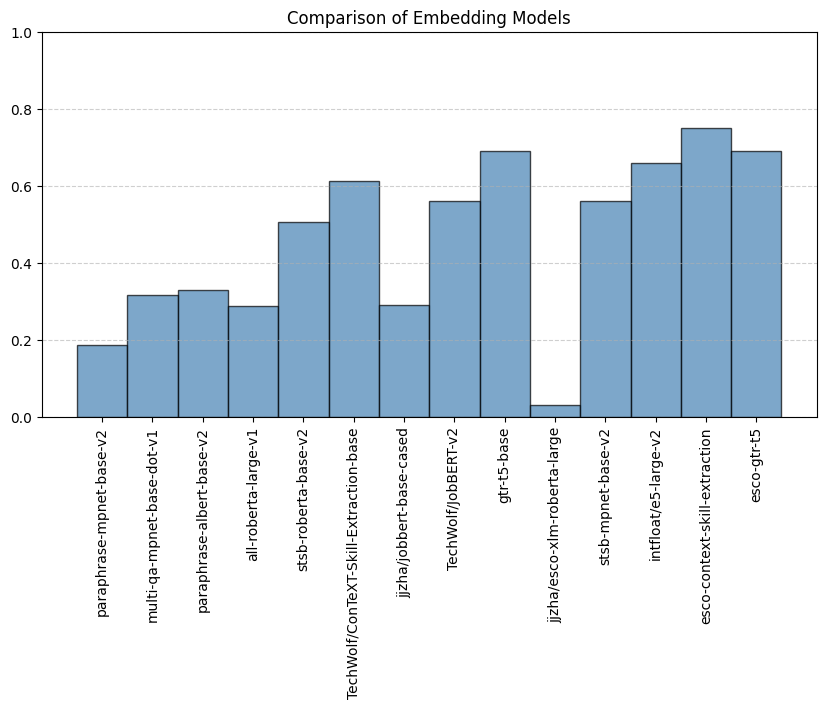

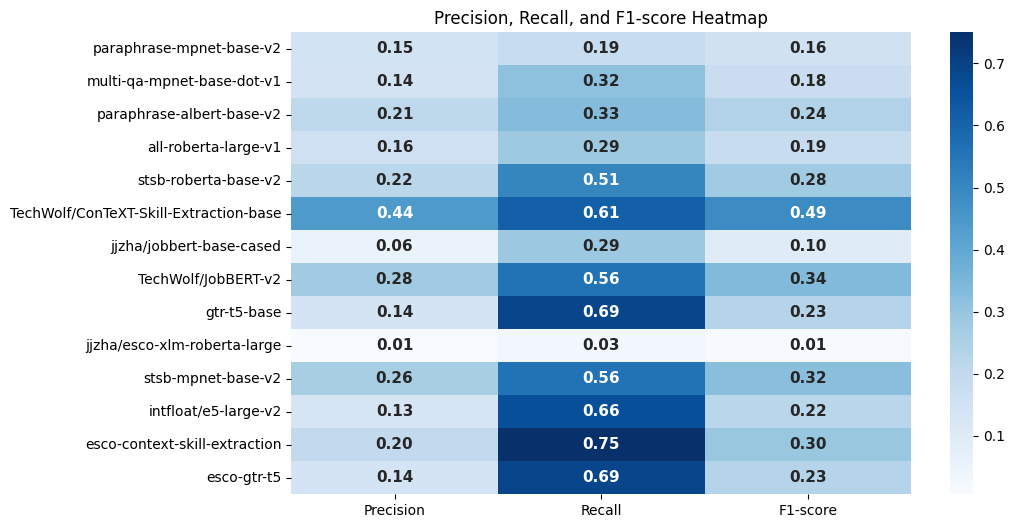

,Precision,Recall,F1-score,Threshold,Skills-count,Matched,Accuracy,Avg-Score
paraphrase-mpnet-base-v2,0.145833,0.186667,0.156778,0.6,216,56 / 300,0.186667,0.2640
multi-qa-mpnet-base-dot-v1,0.143889,0.316667,0.179333,0.6,748,95 / 300,0.316667,0.1316
paraphrase-albert-base-v2,0.211611,0.330000,0.240000,0.6,437,99 / 300,0.330000,0.2340
all-roberta-large-v1,0.160500,0.286667,0.187667,0.6,458,86 / 300,0.286667,0.1927
stsb-roberta-base-v2,0.220500,0.506667,0.278333,0.6,851,152 / 300,0.506667,0.1881
TechWolf/ConTeXT-Skill-Extraction-base,0.442111,0.613333,0.487444,0.6,445,184 / 300,0.613333,0.4379
jjzha/jobbert-base-cased,0.058000,0.290000,0.096667,0.6,1500,87 / 300,0.290000,0.0594
TechWolf/JobBERT-v2,0.276500,0.560000,0.338333,0.6,698,168 / 300,0.560000,0.2548
gtr-t5-base,0.138000,0.690000,0.230000,0.6,1500,207 / 300,0.690000,0.1451
jjzha/esco-xlm-roberta-large,0.006000,0.030000,0.010000,0.6,1500,9 / 300,0.030000,0.0060


In [40]:
plot_histogram(res_df)
print("")
plot_heatmap(res_df)
print("")
res_df

In [26]:
model = SentenceTransformer('abd1987/esco-context-skill-extraction')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/abd1987_esco_context_skill_extraction.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

esco_context_skill_extraction_df = test_samples.copy()
esco_context_skill_extraction_df[['esco', 'score']] = esco_context_skill_extraction_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["esco-context-skill-extraction"] = calculate_metrics(esco_context_skill_extraction_df, esco_df)
print_results(esco_context_skill_extraction_df)

modules.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

225 / 300 (75.00%), (1319)


In [27]:
model = SentenceTransformer('abd1987/esco-gtr-t5')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/abd1987_esco_gtr_t5.npz")
embeddings = np.stack(esco_df[EMBEDDINGS_LABEL].values)

esco_gtr_t5_df = test_samples.copy()
esco_gtr_t5_df[['esco', 'score']] = esco_gtr_t5_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings,
            esco_df,
            THRESHOLD
        )
    )
)
res_df.loc["esco-gtr-t5"] = calculate_metrics(esco_gtr_t5_df, esco_df)
print_results(esco_gtr_t5_df)

modules.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.67k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

207 / 300 (69.00%), (1500)


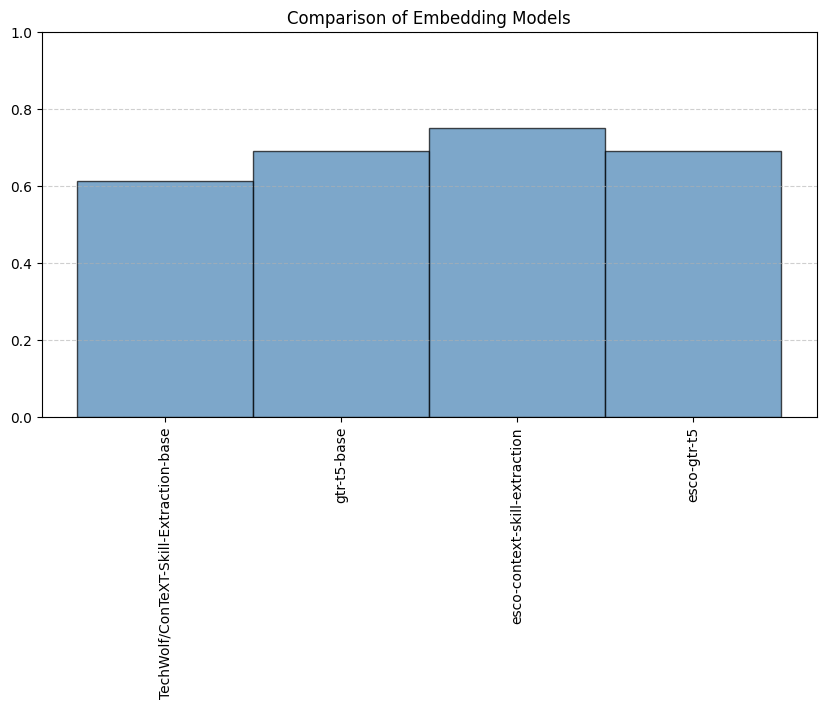

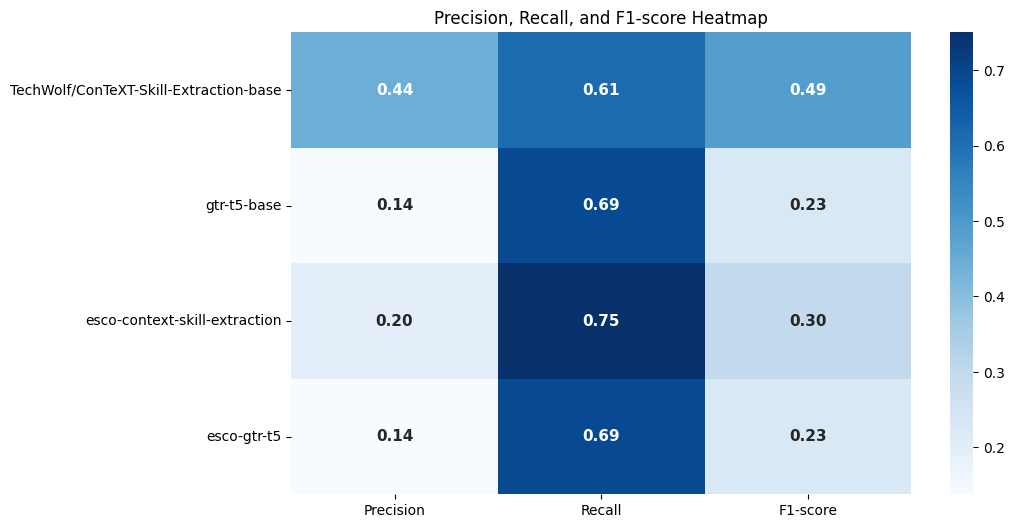

,Precision,Recall,F1-score,Threshold,Skills-count,Matched,Accuracy,Avg-Score
TechWolf/ConTeXT-Skill-Extraction-base,0.442111,0.613333,0.487444,0.6,445,184 / 300,0.613333,0.4379
gtr-t5-base,0.138000,0.690000,0.230000,0.6,1500,207 / 300,0.690000,0.1451
esco-context-skill-extraction,0.197944,0.750000,0.296111,0.6,1319,225 / 300,0.750000,0.1891
esco-gtr-t5,0.138000,0.690000,0.230000,0.6,1500,207 / 300,0.690000,0.1451


In [41]:
new_res_df_rows = ["TechWolf/ConTeXT-Skill-Extraction-base", "gtr-t5-base", "esco-context-skill-extraction", "esco-gtr-t5"]

new_res_df = res_df.loc[res_df.index.isin(new_res_df_rows)]
plot_histogram(new_res_df)
print("")
plot_heatmap(new_res_df)
print("")
new_res_df